# Final Assignment A

Kamile Stankeviciute `ks830`

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import scipy
import math


import sklearn

# from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn.base import TransformerMixin, BaseEstimator 
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.pipeline import Pipeline, FeatureUnion
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error

# from sklearn.ensemble import VotingClassifier

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC

# from sklearn.metrics import accuracy_score

# from sklearn.ensemble import BaggingClassifier
# from sklearn.tree import DecisionTreeClassifier

# from sklearn.ensemble import AdaBoostClassifier

# from sklearn.tree import DecisionTreeRegressor

# from sklearn.ensemble import GradientBoostingRegressor

# import sklearn.linear_model
# import scipy.optimize
# import sklearn.decomposition
# import sklearn.manifold
# import sklearn.model_selection

## Data exploration

Note that the dataset contains a combination of *categorical- and numerical-valued* features. It also contains a number of *missing values*. 
Explore different features in the dataset (e.g., you might want to remove features with mostly missing values), gain insights from the data and report your findings.

Visualise the dataset and the predicted variable:
* `<30` if the patient was readmitted in less than 30 days
* `>30` if the patient was readmitted in more than 30 days
* `No` if there is no record for readmission (but absence of evidence is not evidence of absence ;))

Remove missing columns:
* 'weight': 97% missing
* 'payer_code': 52% missing, generally irrelevant
* 'medical_specialty': 53% missing, ??

In [34]:
# Loading the dataset
pd.set_option('display.max_rows', 500)

diabetic = pd.read_csv('diabetes/diabetic_data_balanced.csv')
diabetic.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [19]:
diabetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 50 columns):
encounter_id                9999 non-null int64
patient_nbr                 9999 non-null int64
race                        9819 non-null object
gender                      9999 non-null object
age                         9999 non-null object
weight                      300 non-null object
admission_type_id           9999 non-null int64
discharge_disposition_id    9999 non-null int64
admission_source_id         9999 non-null int64
time_in_hospital            9999 non-null int64
payer_code                  235 non-null object
medical_specialty           6362 non-null object
num_lab_procedures          9999 non-null int64
num_procedures              9999 non-null int64
num_medications             9999 non-null int64
number_outpatient           9999 non-null int64
number_emergency            9999 non-null int64
number_inpatient            9999 non-null int64
diag_1                   

Counting what proportion of values is present in the dataset:

In [29]:
1 - diabetic.count()/len(diabetic)

encounter_id                0.000000
patient_nbr                 0.000000
race                        0.018002
gender                      0.000000
age                         0.000000
weight                      0.969997
admission_type_id           0.000000
discharge_disposition_id    0.000000
admission_source_id         0.000000
time_in_hospital            0.000000
payer_code                  0.976498
medical_specialty           0.363736
num_lab_procedures          0.000000
num_procedures              0.000000
num_medications             0.000000
number_outpatient           0.000000
number_emergency            0.000000
number_inpatient            0.000000
diag_1                      0.000500
diag_2                      0.004500
diag_3                      0.023502
number_diagnoses            0.000000
max_glu_serum               0.000000
A1Cresult                   0.000000
metformin                   0.000000
repaglinide                 0.000000
nateglinide                 0.000000
c

The above reveals the following variables with significant proportion of missing data:
* `weight`: 97.0% missing
* `payer_code`: 97.6% missing
* `medical_specialty`: 36.3% missing

I will remove `weight` and `payer_code` from further analysis.

In [35]:
diabetic = diabetic.drop(['weight', 'payer_code'], axis=1)

I am also removing `encounter_id` and `patient_nbr` because I don't want the machine learning methods to learn to identify problematic patients from their identifier, and only use other data related to the particular encounter.

In [39]:
diabetic = diabetic.drop(['encounter_id', 'patient_nbr'], axis=1)

For `medical_specialty`:

In [37]:
diabetic['medical_specialty'].value_counts()

InternalMedicine                        1974
Family/GeneralPractice                  1281
Cardiology                               866
Surgery-General                          343
Nephrology                               209
Orthopedics-Reconstructive               203
Psychiatry                               172
Pulmonology                              160
Orthopedics                              132
Surgery-Cardiovascular/Thoracic          117
Urology                                  115
ObstetricsandGynecology                  107
Hematology/Oncology                       77
PhysicalMedicineandRehabilitation         77
Surgery-Neuro                             64
Gastroenterology                          63
Emergency/Trauma                          63
Pediatrics-Endocrinology                  63
Pediatrics                                49
Pediatrics-CriticalCare                   46
Endocrinology                             39
Radiology                                 18
Otolaryngo

In [11]:
print(diabetic.describe())

       encounter_id   patient_nbr  admission_type_id  \
count  9.999000e+03  9.999000e+03        9999.000000   
mean   3.216415e+07  2.616384e+07           2.455546   
std    2.289500e+07  3.362519e+07           1.865877   
min    1.252200e+04  1.350000e+02           1.000000   
25%    1.622300e+07  2.425828e+06           1.000000   
50%    2.698463e+07  8.794098e+06           2.000000   
75%    3.790203e+07  3.230309e+07           3.000000   
max    9.448424e+07  1.151968e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count               9999.000000          9999.000000       9999.000000   
mean                   4.733073             6.721972          4.838984   
std                    6.791574             4.995468          3.167283   
min                    1.000000             1.000000          1.000000   
25%                    1.000000             2.000000          2.000000   
50%                    1.000000             7.00000

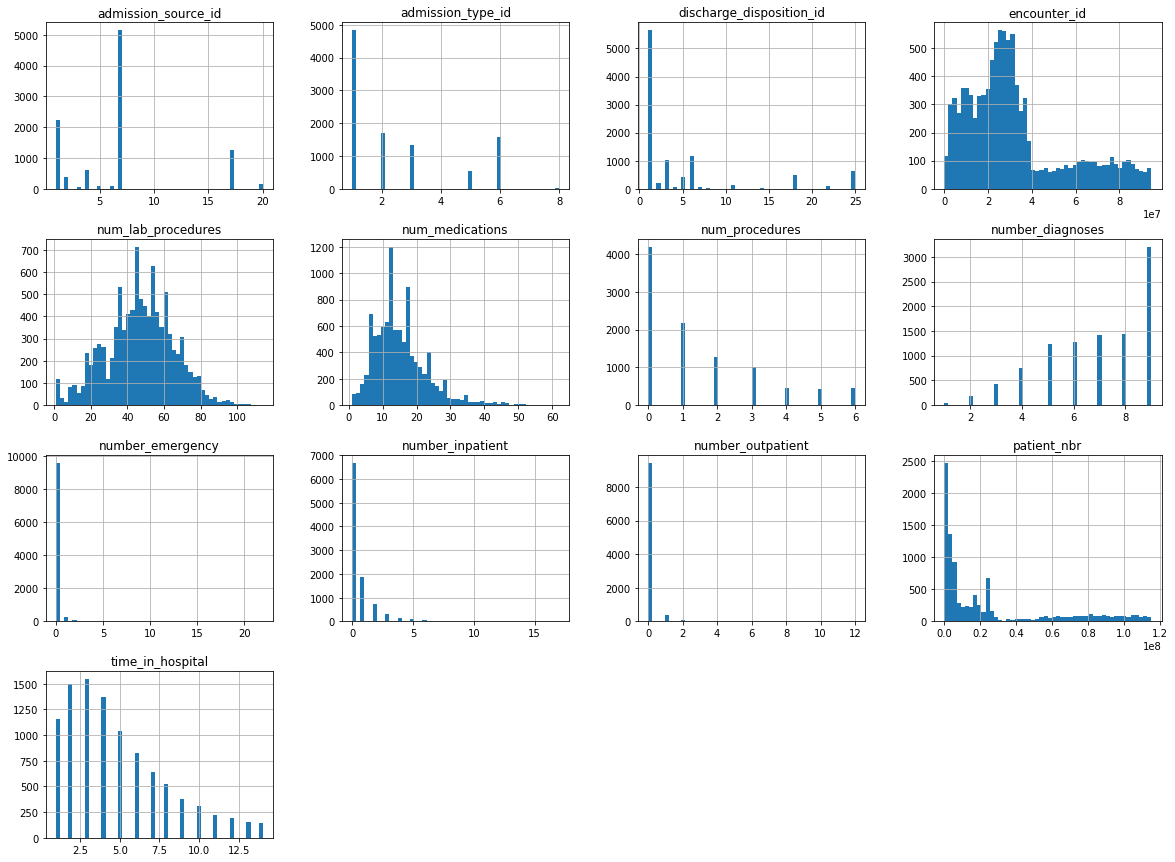

In [13]:
%matplotlib inline 
import matplotlib.pyplot as plt

diabetic.hist(bins=50, figsize=(20,15))
plt.show()

In [15]:
diabetic['patient_nbr'].value_counts()

1660293     15
3481272     12
3401055     12
23643405    11
633906      11
            ..
7067862      1
78346458     1
5812695      1
70858503     1
102402       1
Name: patient_nbr, Length: 7944, dtype: int64

In [17]:
diabetic['race'].value_counts()

Caucasian          7181
AfricanAmerican    2271
Hispanic            195
Other               130
Asian                42
Name: race, dtype: int64